In [1]:
from astropy.io import fits
import numpy as np
import healpy as hp
import seaborn as sns
import matplotlib.pyplot as plt
from astropy import coordinates as coo, units as u

In [3]:
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['font.size'] = 15

In [8]:
quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
c = coo.SkyCoord(ra=quasar_cata['ra'], dec=quasar_cata['dec'], unit='deg')
c_plot = c[np.random.choice(len(c), 3000)]

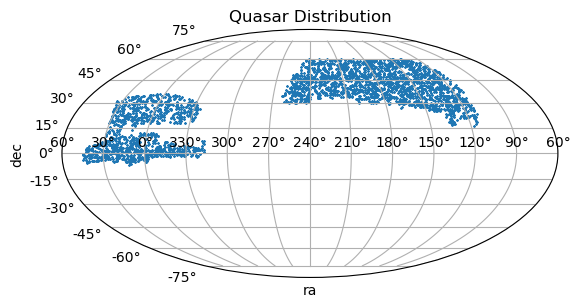

In [3]:
fig = plt.figure()
axe_quasar = fig.add_subplot(111, projection='mollweide')
axe_quasar.grid(True)
central_longitude = -120
axe_quasar.scatter(-(c_plot.ra - central_longitude*u.deg).wrap_at('180d').radian, c_plot.dec.radian, s=1, marker='*')
xticks = np.arange(-180, 181, 30)  # 每30度一个刻度
# xticks = (xticks + 180) % 360 - 180
axe_quasar.set_xticks(np.radians(xticks))  # 调整刻度位置
f = lambda x: x % 360
axe_quasar.set_xticklabels([f"{f(-x+central_longitude)}°" for x in xticks])
axe_quasar.set_xlabel('ra')
axe_quasar.set_ylabel('dec')
axe_quasar.set_title('Quasar Distribution')
# plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/quasar-map.pdf')
plt.show()

In [9]:
map_data = np.load('../catalogue/CMB_smoothed_6.npy')   # the 6 arcsec smoothed map
l, b, kappa = map_data
phi = l
theta = np.pi/2 - b
Nside = 2048
map = np.ones(hp.nside2npix(Nside)) * hp.UNSEEN
index = hp.ang2pix(Nside, theta, phi)
map[index] = kappa

xsize = 2000
ysize = xsize//2

theta = np.linspace(np.pi, 0, ysize)
phi   = np.linspace(-np.pi, np.pi, xsize)
longitude = np.radians(np.linspace(-180, 180, xsize))
latitude = np.radians(np.linspace(-90, 90, ysize))

# project the map to a rectangular matrix xsize x ysize
PHI, THETA = np.meshgrid(phi, theta)
grid_pix = hp.ang2pix(Nside, THETA, PHI)

grid_map = map[grid_pix]
grid_map = np.ma.masked_array(grid_map, grid_map < -1e10)

vmin = grid_map.min()
vmax = grid_map.max()

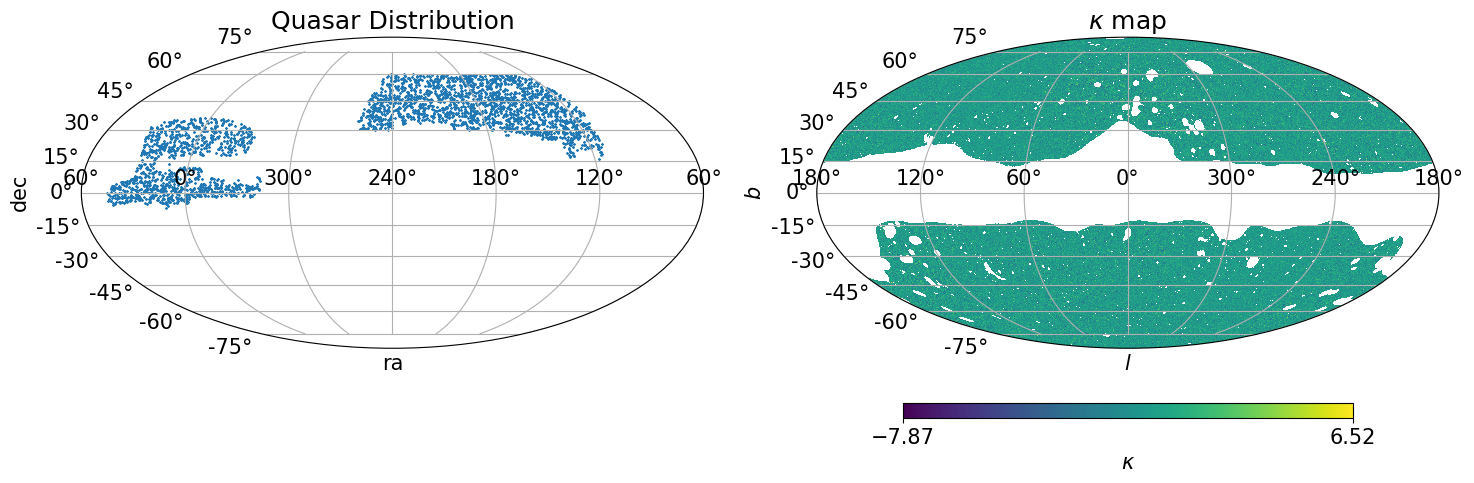

In [7]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection':'mollweide'}, figsize=(15, 5))
axe_quasar, axe_kappa = axes
axe_quasar.grid(True)

central_longitude = -120
axe_quasar.scatter(-(c_plot.ra - central_longitude*u.deg).wrap_at('180d').radian, c_plot.dec.radian, s=1, marker='*')

xticks = np.arange(-180, 181, 60)
axe_quasar.set_xticks(np.radians(xticks))
f = lambda x: x % 360
axe_quasar.set_xticklabels([f"{f(-x+central_longitude)}°" for x in xticks])

axe_quasar.set_xlabel('ra')
axe_quasar.set_ylabel('dec')
axe_quasar.set_title('Quasar Distribution')

image = axe_kappa.pcolormesh(longitude[::-1], latitude, grid_map, 
                             vmin=vmin, vmax=vmax, rasterized=True)

axe_kappa.grid(True)

axe_kappa.set_xticks(np.radians(xticks))
axe_kappa.set_xticklabels([f"{f(-x)}°" for x in xticks])

axe_kappa.set_xlabel('$l$')
axe_kappa.set_ylabel('$b$')
axe_kappa.set_title('$\\kappa$ map')

# Create a custom position for the colorbar that's centered but shorter
# Instead of using the cax parameter, we'll create a new axes at a specific position
fig.subplots_adjust(bottom=0.1)  # Make room at the bottom
# Create a custom axes for the colorbar
# [left, bottom, width, height] in figure coordinates (0-1)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout but leave room for colorbar

b = axe_kappa.get_position()
pos_c = (b.xmin + b.xmax) / 2

cbar_ax = fig.add_axes([pos_c - 0.15, 0.1, 0.3, 0.03])  # Centered under kappa plot, shorter width
cbar = fig.colorbar(image, cax=cbar_ax, orientation='horizontal', ticks=[vmin, vmax])
cbar.set_label('$\\kappa$')

plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/sky-map.pdf')
plt.show()

# galactic coords

In [4]:
map_data = np.load('../catalogue/CMB_smoothed_6.npy')   # the 6 arcsec smoothed map
l, b, kappa = map_data
phi = l
theta = np.pi/2 - b
Nside = 2048
map = np.ones(hp.nside2npix(Nside)) * hp.UNSEEN
index = hp.ang2pix(Nside, theta, phi)
map[index] = kappa

central_longitude = 120

xsize = 2000
ysize = xsize//2

theta = np.linspace(np.pi, 0, ysize)
phi   = np.linspace(-np.pi, np.pi, xsize)
longitude = np.radians(np.linspace(-180, 180, xsize))
latitude = np.radians(np.linspace(-90, 90, ysize))

phi = phi + central_longitude / 180 * np.pi
phi = (phi + np.pi) % (2*np.pi) - np.pi

# project the map to a rectangular matrix xsize x ysize
PHI, THETA = np.meshgrid(phi, theta)
grid_pix = hp.ang2pix(Nside, THETA, PHI)

grid_map = map[grid_pix]                    # rotated kappa map
grid_map = np.ma.masked_array(grid_map, grid_map < -1e10)

In [5]:
vmin = grid_map.min()
vmax = grid_map.max()

In [6]:
import matplotlib.colors as mcolors
class NonLinearNormalize(mcolors.Normalize):
    def __init__(self, vmin=-6, vmax=6, steepness=2.0):
        super().__init__(vmin=vmin, vmax=vmax)
        self.steepness = steepness
    
    def __call__(self, value, clip=None):
        # First normalize to [-1, 1]
        normalized = 2 * (value - self.vmin) / (self.vmax - self.vmin) - 1
        
        # Apply tanh function for fast change near zero, slow at extremes
        # tanh maps [-inf, inf] to [-1, 1] with steep slope around 0
        transformed = np.tanh(self.steepness * normalized)
        
        # Map back to [0, 1] for colormap
        result = (transformed + 1) / 2
        
        return np.ma.masked_array(result, mask=False)

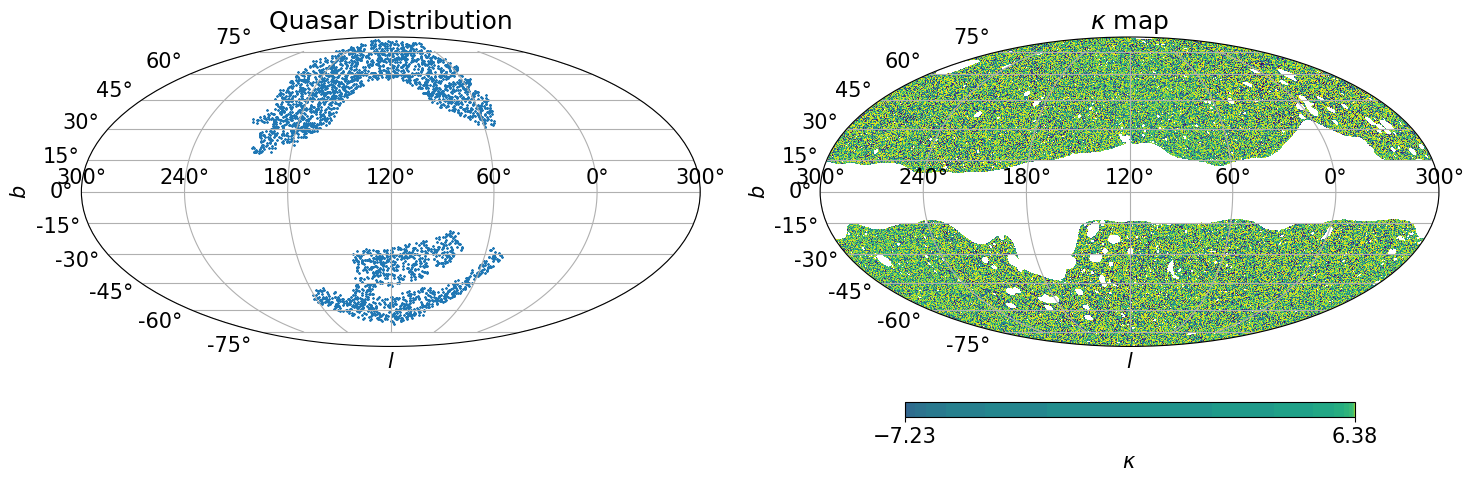

In [9]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection':'mollweide'}, figsize=(15, 5))
axe_quasar, axe_kappa = axes
axe_quasar.grid(True)

central_longitude = 120
axe_quasar.scatter(-(c_plot.galactic.l - central_longitude*u.deg).wrap_at('180d').radian, c_plot.galactic.b.radian, s=1, marker='*')

xticks = np.arange(-180, 181, 60)
axe_quasar.set_xticks(np.radians(xticks))
f = lambda x: x % 360
axe_quasar.set_xticklabels([f"{f(-x+central_longitude)}°" for x in xticks])

axe_quasar.set_xlabel('$l$')
axe_quasar.set_ylabel('$b$')
axe_quasar.set_title('Quasar Distribution')

image = axe_kappa.pcolormesh(-longitude, latitude, grid_map, cmap='viridis',
                             rasterized=True, norm=NonLinearNormalize(vmin, vmax, 7))
# image = axe_kappa.pcolormesh(-longitude, latitude, grid_map, 
#                              rasterized=True, norm=NonLinearNormalize(vmin, vmax, 5))


axe_kappa.grid(True)

axe_kappa.set_xticks(np.radians(xticks))
axe_kappa.set_xticklabels([f"{f(-x+central_longitude)}°" for x in xticks])

axe_kappa.set_xlabel('$l$')
axe_kappa.set_ylabel('$b$')
axe_kappa.set_title('$\\kappa$ map')

# Create a custom position for the colorbar that's centered but shorter
# Instead of using the cax parameter, we'll create a new axes at a specific position
fig.subplots_adjust(bottom=0.1)  # Make room at the bottom
# Create a custom axes for the colorbar
# [left, bottom, width, height] in figure coordinates (0-1)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout but leave room for colorbar

b = axe_kappa.get_position()
pos_c = (b.xmin + b.xmax) / 2

cbar_ax = fig.add_axes([pos_c - 0.15, 0.1, 0.3, 0.03])  # Centered under kappa plot, shorter width
cbar = fig.colorbar(image, cax=cbar_ax, orientation='horizontal', ticks=[vmin, vmax])
cbar.set_label('$\\kappa$')

plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/sky-map.pdf')
plt.show()